In [9]:
# Standard Imports
import pandas as pd
import h5py
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pathlib
import tensorflow as tf
from keras import metrics
from keras.constraints import max_norm
gpus = tf.config.experimental.list_physical_devices("GPU")
path = pathlib.Path.cwd()

In [2]:
path.parent.parent

PosixPath('/local_disk/james/Taylor_data')

In [3]:
import sys
sys.path.insert(0, path.parent)

In [2]:
rinv="0p3"

In [3]:
# tp_file = open(f"sherpa_results/{rinv}.json", "r")
tp = np.load("./sherpa_results/"+rinv+"/best_results.npy", allow_pickle = True)
tp = tp.item()

In [4]:
tp

{'Trial-ID': 39,
 'Iteration': 9,
 'batch_size': 512.0,
 'dense_units_1': 330.0,
 'dense_units_2': 208.0,
 'dense_units_3': 294.0,
 'dropout_0': 0.033181350208940474,
 'dropout_1': 0.011722791167547264,
 'dropout_2': 0.19895612831997633,
 'filter_1': 361.0,
 'filter_2': 271.0,
 'filter_3': 248.0,
 'learning_rate': 0.0003930583204896917,
 'Objective': 0.8055737018585205,
 'accuracy': 0.7251466512680054,
 'auc': 0.8055737018585205,
 'loss': 0.6003246307373047}

In [17]:
# Silnence output of tensorflow/keras about GPU status
import os

# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)


# Keras imports
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics
from keras.constraints import max_norm


def get_model(run_type, tp, input_shape=None):
    if run_type == "LL":
        model = Sequential()
        model.add(
            Conv2D(tp["filter_1"], (3, 3), activation="relu", input_shape=(32, 32, 1),)
        )
        model.add(MaxPooling2D((2, 2)))
        model.add(
            Conv2D(
                tp["filter_2"],
                (3, 3),
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        model.add(MaxPooling2D((2, 2)))
        model.add(
            Conv2D(
                tp["filter_3"],
                (3, 3),
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        model.add(MaxPooling2D((2, 2)))

        model.add(Flatten())
        # model.add(Dropout(tp["dropout_0"]))
        model.add(
            Dense(
                tp["dense_units_1"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        # model.add(Dropout(tp["dropout_1"]))
        model.add(
            Dense(
                tp["dense_units_2"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        # model.add(Dropout(tp["dropout_2"]))
        model.add(
            Dense(
                tp["dense_units_3"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=tp["learning_rate"]),
            metrics=["accuracy", metrics.AUC(name="auc")],
        )
    elif run_type == "HL":
        model = Sequential()
        model.add(Flatten(input_shape=(input_shape,)))
        # model.add(Dropout(tp["dropout_0"]))
        model.add(
            Dense(
                tp["dense_units_1"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        # model.add(Dropout(tp["dropout_1"]))
        model.add(
            Dense(
                tp["dense_units_2"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        # model.add(Dropout(tp["dropout_2"]))
        model.add(
            Dense(
                tp["dense_units_3"],
                activation="relu",
                kernel_constraint=max_norm(3),
                bias_constraint=max_norm(3),
            )
        )
        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(lr=tp["learning_rate"]),
            metrics=["accuracy", metrics.AUC(name="auc")],
        )

    return model


In [10]:
def get_model(tp):
    inputs = tf.keras.Input(shape=(32,32))
    x = inputs
    x = tf.expand_dims(x,axis=-1)
#     x = get_filter(1)(x)
    x = tf.keras.layers.Conv2D(tp["filter_1"], kernel_size=(3, 3), activation='relu', input_shape=(32,32,1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(tp["filter_2"], kernel_size=(3, 3), activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(tp["filter_3"], kernel_size=(3, 3), activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dropout(tp["dropout_0"])(x)
    x = tf.keras.layers.Dense(tp["dense_units_1"], activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    x = tf.keras.layers.Dropout(tp["dropout_1"])(x)
    x = tf.keras.layers.Dense(tp["dense_units_2"], activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x)
    x = tf.keras.layers.Dropout(tp["dropout_2"])(x)
    x = tf.keras.layers.Dense(tp["dense_units_3"], activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(x) # 3rd 
    
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    modelCNN_basis = tf.keras.Model(inputs=inputs, outputs=x, name='CNN_basis')
    modelCNN_basis.compile(optimizer=keras.optimizers.Adam(lr=tp["learning_rate"]) ,
                     loss="binary_crossentropy",
                     metrics=['accuracy', metrics.AUC(name="auc")])
    print(tp.values)
    modelCNN_basis.summary()
#     print("Droup out :", dp1, " ", dp2)
#     print("lr :", lr)
                           
    return modelCNN_basis

In [7]:
def scale_data(x, mean=True):
    mean = np.mean(x)
    std = np.std(x)
    if std == 0:
        std = 1
    return (x - mean) / std

def process_data(X):
    X = np.log(1.0 + X) / 4.0
    X = scale_data(X)
    return X

In [19]:
model_CNN = get_model(tp)

<built-in method values of dict object at 0x7fe2615e23a8>
Model: "CNN_basis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_2 (Te [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 361)       3610      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 361)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 271)       880750    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 271)         0         
_________________________________________________________________

In [12]:
rinv = "0p3"
file_path = "LL-"+rinv+".h5"
hdf_file = path.parent.parent/"Train"/file_path
hf = h5py.File(hdf_file, "r")

In [13]:
X = hf["features"][:]
Y = hf["targets"][:]

In [14]:
X = process_data(X)


In [14]:
# X = np.expand_dims(X, axis=-1)

In [15]:
N = len(X)
Ntrain, Nval, Ntest = int(N/5*4),  int(N/10),  int(N/10)
Xim_train, Xim_val, Xim_test = X[:Ntrain], X[Ntrain:Nval+Ntrain], X[Nval+Ntrain:N]
yim_train, yim_val, yim_test = Y[:Ntrain], Y[Ntrain:Nval+Ntrain], Y[Nval+Ntrain:N]

In [20]:
model_type = "CNN3_basis_preprocessing"
save_dir = './Keras_Tunner/'
model_name = '%s_model_test' % model_type
i = 3
opt = ["Adadelta", "SGD", "Adagrad", "Adam"]
optn = opt[i]
csv_logger = keras.callbacks.CSVLogger('./CNN3_all_'+rinv+'_'+optn+'_filter_preprocessing.csv')
N_size = len(Xim_val)
callbacks = [keras.callbacks.EarlyStopping(patience=10, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath="./test", verbose=1, save_best_only=True),
            csv_logger]

In [21]:
history = model_CNN.fit(
    Xim_train,
    yim_train,
    epochs=200,
    verbose=0,
    steps_per_epoch=int(N_size * 0.80) // tp["batch_size"],
    validation_data=(Xim_val, yim_val),
    callbacks=callbacks,
    )


Epoch 00001: val_loss improved from inf to 0.50218, saving model to ./test
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./test/assets

Epoch 00002: val_loss improved from 0.50218 to 0.43884, saving model to ./test
INFO:tensorflow:Assets written to: ./test/assets

Epoch 00003: val_loss improved from 0.43884 to 0.39435, saving model to ./test
INFO:tensorflow:Assets written to: ./test/assets

Epoch 00004: val_loss improved from 0.39435 to 0.35425, saving model to ./test
INFO:tensorflow:Assets written to: ./test/assets

Epoch 00005: val_loss improved from 0.35425 to 0.32919, saving model to ./test
INFO:tensorflow:Assets written to: ./test/assets

Epoch 00006: val_loss improved from 0.32919 to 0.32909, saving model to ./test
INFO:tensorflow:Assets written to: ./test/ass

In [28]:
model_CNN.save("./CNN3_all_"+rinv+"_"+optn+"_filter_preprocessing")


INFO:tensorflow:Assets written to: ./CNN3_all_0p3_Adam_filter_preprocessing/assets


In [31]:
model_CNN = tf.keras.models.load_model("./CNN3_all_"+rinv+"_"+optn+"_filter_preprocessing")

In [29]:
model_CNN = tf.keras.models.load_model("./test")

In [25]:
from sklearn.metrics import roc_curve, auc


The area under the curves are:
AUC:0.029983192
AUC:0.970016808


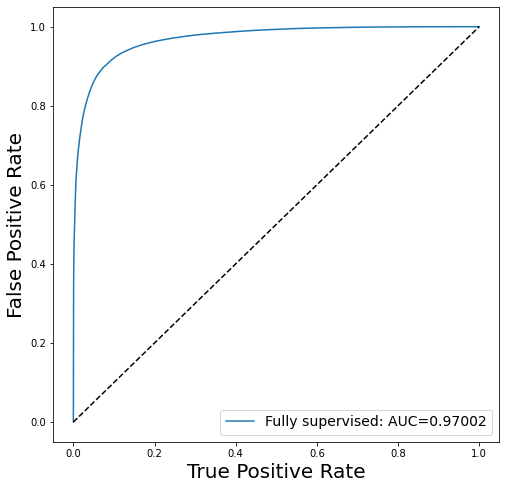

In [32]:
y_score=model_CNN.predict(Xim_test)[:,0]
y_score = np.hstack(y_score)
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( yim_test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
if roc_auc<0.5:
    a = tpr
    tpr = fpr
    fpr = a
    roc_auc = 1 - roc_auc
    print("AUC:{0:.9f}".format(roc_auc))
    
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,8))

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.5f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.legend()
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)

plt.legend(prop={'size': 14})



plt.savefig("./CNN3_all_"+rinv+"_"+optn+"_filter_roc_preprocessing.png")

# hf = h5py.File("./Keras_Tunner/PR_all_"+rinv+"_"+optn+"_filter_preprocessing.h5", 'w')
hf = h5py.File("./PR3_all_"+rinv+"_"+optn+"_filter_preprocessing.h5", 'w')

hf.create_dataset('fpr', data=fpr)
hf.create_dataset('tpr', data=tpr)
hf.close()


plt.show()

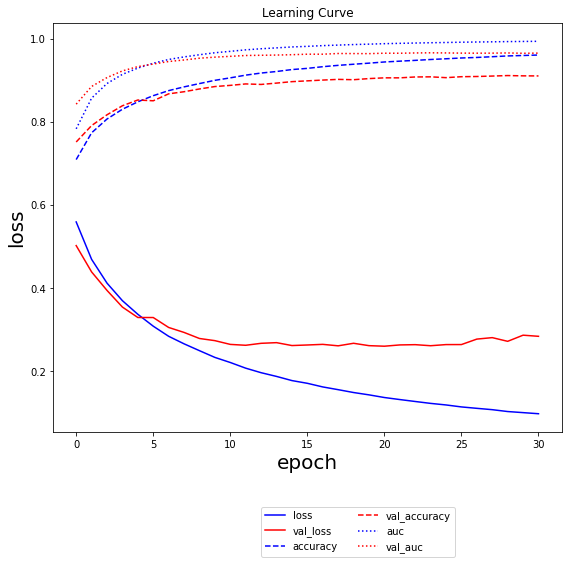

In [27]:
plt.figure(figsize=(8,8))
# LOSS = pd.read_csv(save_dir+"CNN_"+rinv+"_"+optn+"_filter.csv")
# LOSS = pd.read_csv(save_dir+"CNN_all_"+rinv+"_"+optn+"_filter_preprocessing.csv")
LOSS = pd.read_csv("./CNN3_all_"+rinv+"_"+optn+"_filter_preprocessing.csv")


plt.title("Learning Curve")
plt.plot(LOSS["loss"], label='loss',c='blue')
plt.plot(LOSS["val_loss"], label='val_loss',c='red')
plt.plot(LOSS["accuracy"], linestyle='--', label='accuracy',c='blue')
plt.plot(LOSS["val_accuracy"], linestyle='--', label='val_accuracy',c='red')

plt.plot(LOSS["auc"], linestyle=':', label='auc',c='blue')
plt.plot(LOSS["val_auc"], linestyle=':', label='val_auc',c='red')
# plt.plot([0, 1], [1, 1], '--')

# plt.ylim([0.3,1])
plt.ylabel('loss',fontsize=20)
plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
# plt.savefig("./Keras_Tunner/CNN_"+rinv+"_"+optn+"_filter_loss.png")
# plt.savefig("./Keras_Tunner/CNN_all_"+rinv+"_"+optn+"_filter_loss_preprocessing.png")
plt.savefig("./CNN3_all_"+rinv+"_"+optn+"_filter_loss_preprocessing.png")



plt.show()

In [ ]:
def test_val_set(rinv, split):
    f = h5py.File(path.parent / "data" / "jet_images" / f"LL-{rinv}.h5", "r")
    N = f["targets"].shape[0]
    if split == "val":
        a = int(N * 0.8)
        b = int(N * 0.9)
    if split == "test":
        a = int(N * 0.9)
        b = -1
    X = f["features"][a:b]
    y = f["targets"][a:b]
    X = process_data(X)
    return N, X, y


def generator(rinv, batch_size, fullSet=False):
    while True:
        f = h5py.File(path.parent / "data" / "jet_images" / f"LL-{rinv}.h5", "r")
        N = f["targets"].shape[0]
        start = 0
        if not fullSet:
            N = int(N * 0.80)
        end = batch_size
        while start < N:
            X = f["features"][start:end]
            X = process_data(X)
            y = f["targets"][start:end]
            yield X, y
            start += batch_size
            end += batch_size


def train_cnn(rinv, retrain=False):
    # To retrain, remove the old model
    model_file = path / "models" / f"{rinv}.h5"
    if retrain and model_file.exists():
        os.remove(model_file)

    # Trainig parameters from the sherpa optimization
    tp_file = open(f"sherpa_results/{rinv}.json", "r")
    tp = json.load(tp_file)
    tp.close()
    model = get_model(tp)

    training_data = generator(rinv=rinv, batch_size=tp["batch_size"])
    _, X_test, y_test = test_val_set(rinv=rinv, split="test")
    N_size, X_val, y_val = test_val_set(rinv=rinv, split="val")

    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ModelCheckpoint(
            filepath=model_file, verbose=1, save_best_only=True
        ),
    ]

    history = model.fit(
        training_data,
        epochs=200,
        verbose=2,
        steps_per_epoch=int(N_size * 0.80) // tp["batch_size"],
        validation_data=(X_val, y_val),
        callbacks=callbacks,
    )

    return model, X_test, y_test


if __name__ == "__main__":
    rinvs = ["0p0", "0p3", "1p0"]
    for rinv in rinvs:
        # Train a new model (or load the existing one if available)
        model, X_test, y_test = train_cnn(rinv, retrain=True)

        # Plot the ROC curve
        auc_val = plot_roc(X_test, y_test, rinv)
        print(rinv, auc_val)

        # Generate predictions for the full dataset
        X = generator(rinv=rinv, batch_size=batch_size, fullSet=True)
        full_predictions = model.predict(X)  # np.concatenate(model.predict(X))
        print(full_predictions)

        # Save the predictions
        np.save(path / "predictions" / "ll_predictions.npy", full_predictions)